# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 3

## Predição de uma série temporal empregando um modelo linear e um não-linear
dataset: Sunspot  
source: https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/sunspot.long.data

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Ito

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

Using TensorFlow backend.


### 6.2. Carregando a base de dados e apresentando sua composição

Download datase

In [2]:
!wget -nc -q https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/sunspot.long.data

Load dataset

In [3]:
# fwf: fixed width formatted
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
df = pd.read_fwf('/content/sunspot.long.data', sep='\t', skiprows=1, skipfooter=10, names=months)
df

,1,2,3,4,5,6,7,8,9,10,11,12
1749,96.7,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0
1750,122.2,126.5,148.7,147.2,150.0,166.7,142.3,171.7,152.0,109.5,105.5,125.7
1751,116.7,72.5,75.5,94.0,101.2,84.5,110.5,99.7,39.2,38.7,47.5,73.3
1752,58.3,83.3,118.3,98.8,99.5,66.0,130.7,48.8,45.2,77.7,62.7,66.7
1753,73.3,53.3,76.2,63.3,60.0,52.8,36.7,65.0,46.7,41.7,33.3,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2014,117.0,146.1,128.7,112.5,112.5,102.9,100.2,106.9,130.0,90.0,103.6,112.9
2015,93.0,66.7,54.5,75.3,88.8,66.5,65.8,64.4,78.6,63.6,62.2,58.0
2016,57.0,56.4,54.1,37.9,51.5,20.5,32.4,50.2,44.6,33.4,21.4,18.5
2017,26.1,26.4,17.7,32.3,18.9,19.2,18.3,33.1,43.6,13.2,5.7,8.2


In [4]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
#----------------------------
series = df.to_numpy().reshape(1,-1).squeeze()
print(series)
print(series.shape)

[ 96.7 104.3 116.7 ...   4.9   4.9   3.1]
(3240,)


### 6.3. Exibindo o comportamento temporal da série

Text(0, 0.5, 'Número de manchas solares mensais')

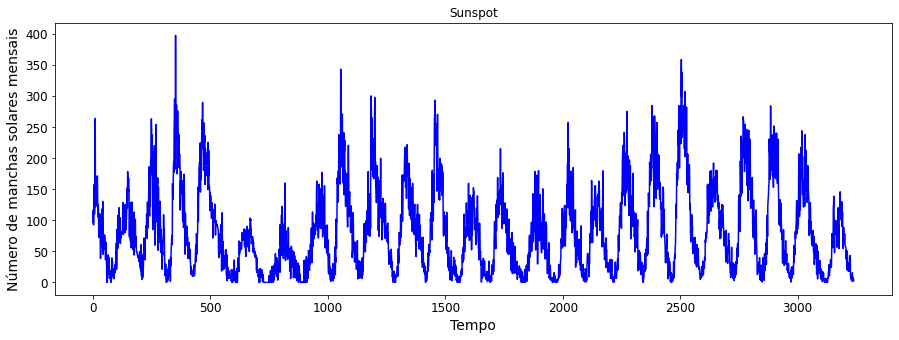

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue')
plt.title('Sunspot')
plt.xlabel('Tempo')
plt.ylabel('Número de manchas solares mensais')

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [6]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P3_x_train.txt', x_train)
    np.savetxt('Q6P3_y_train.txt', y_train)
    np.savetxt('Q6P3_x_valid.txt', x_valid)
    np.savetxt('Q6P3_y_valid.txt', y_valid)
    np.savetxt('Q6P3_x_test.txt', x_test)
    np.savetxt('Q6P3_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [7]:
# create train, test data
seq_len = 130 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2487, 130)
y_train.shape =  (2487, 1)
x_valid.shape =  (311, 130)
y_valid.shape =  (311, 1)
x_test.shape =  (311, 130)
y_test.shape =  (311, 1)


### 6.5. Visualização do comportamento da série temporal de teste

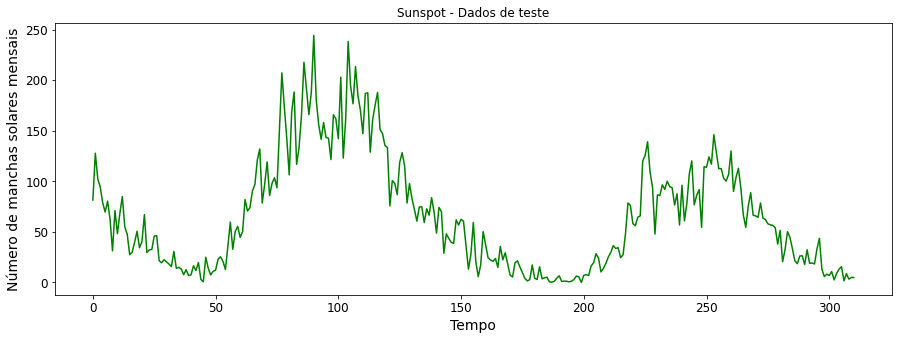

In [8]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Sunspot - Dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Número de manchas solares mensais')
plt.show()

### 6.6. Pré-processamento

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# print data before scaling
print(x_train)
shape = x_train.shape
x_train = scaler.fit_transform(x_train.reshape(-1,1)).squeeze().reshape(shape)
#----------------------------
# print data after scaling
print(f'\n{x_train}')
#----------------------------
# scale x_valid and x_test too (without using them for scaling)
shape_valid = x_valid.shape
shape_test  = x_test.shape
x_valid = scaler.transform(x_valid.reshape(-1,1)).squeeze().reshape(shape_valid)
x_test  = scaler.transform(x_test.reshape(-1,1)).squeeze().reshape(shape_test)

[[ 96.7 104.3 116.7 ... 118.8 128.7  99.5]
 [104.3 116.7  92.8 ... 128.7  99.5  77.2]
 [116.7  92.8 141.7 ...  99.5  77.2  95. ]
 ...
 [104.1 175.6 167.7 ...  72.6  71.1  81.2]
 [175.6 167.7 156.7 ...  71.1  81.2  81. ]
 [167.7 156.7 193.4 ...  81.2  81.   99.8]]

[[0.24284279 0.26192868 0.29306881 ... 0.29834254 0.32320442 0.24987443]
 [0.26192868 0.29306881 0.23304872 ... 0.32320442 0.24987443 0.19387243]
 [0.29306881 0.23304872 0.35585133 ... 0.24987443 0.19387243 0.23857358]
 ...
 [0.26142642 0.44098443 0.42114515 ... 0.18232044 0.17855349 0.20391763]
 [0.44098443 0.42114515 0.39352084 ... 0.17855349 0.20391763 0.20341537]
 [0.42114515 0.39352084 0.48568559 ... 0.20391763 0.20341537 0.25062783]]


Text(0, 0.5, 'Número de manchas solares mensais')

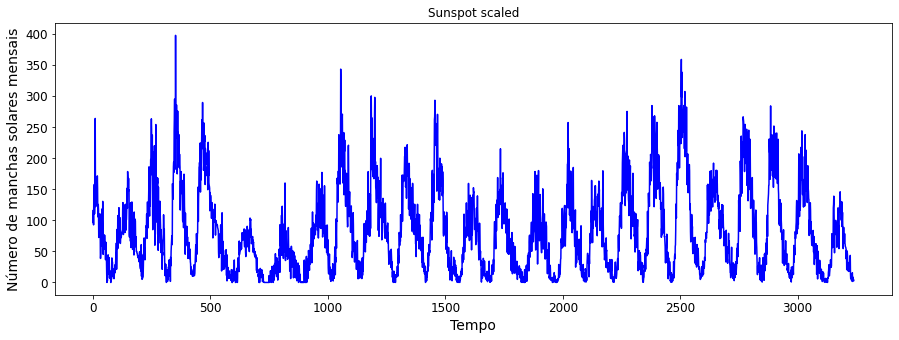

In [10]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue')
plt.title('Sunspot scaled')
plt.xlabel('Tempo')
plt.ylabel('Número de manchas solares mensais')

### 6.7. Sintetizando um preditor linear

In [11]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[ -9.30154885   6.57243481  10.26513942  -2.35773414  -1.77914417
   2.42814828  -3.10300687   8.5778506    0.93032802  -1.17836153
   4.17615122  -3.91651345  -6.03243859   3.62049451   5.83405246
  -1.930196   -18.62159468  12.14238252   3.50645717  13.51683505
 -13.42200264 -12.69588832  11.75977456  -4.22896127  -5.32159792
   1.47762843   3.55188353  -7.74775946  17.09514045  -4.10178421
   3.49842284   0.98648841   5.32670498  -3.65521396  10.9559711
  -3.92576356   8.67260483  -2.14265488  16.55483983  -3.17463954
   3.5370465    3.59179198 -12.30175359 -16.69704445  -2.50080936
  -3.10537321  15.86266404  -9.04613884   7.50309712  -8.59989846
   1.56217409  -4.51609659  -7.87603586  -8.26719954   7.37063466
   3.66401316  -5.68786062  10.59186346   1.15333684   3.35907623
  11.8370368   -6.77286536  -3.22520878  17.35296145 -12.61219425
   3.61048372   1.24980973  -5.20281172   7.86274454  -5.843757
   8.9829828  -13.08921102 -11.47747898  -4.918

#### 6.7.1. Visualização do desempenho do preditor linear

In [12]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
592.3783542882018
EQM final de validação após o término do treinamento - Preditor Linear
692.2225522323569
EQM final de teste após o término do treinamento - Preditor Linear
406.03526221723206


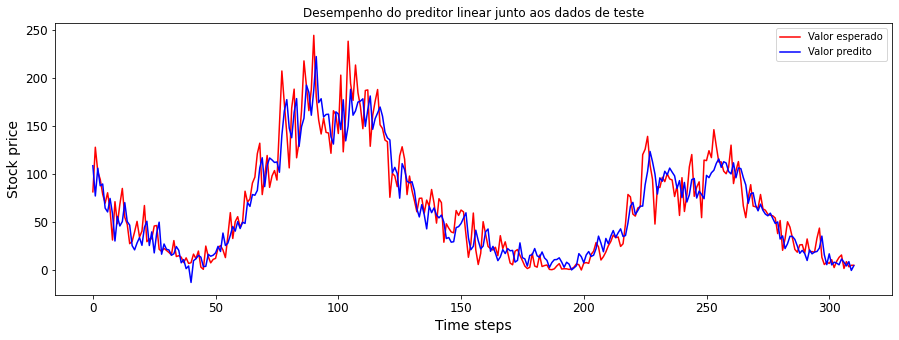

In [13]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear MLP

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
EPOCHS = 200
PATIENCE = 20
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/200
78/78 [==============================] - 0s 5ms/step - loss: 10971.4502 - val_loss: 16982.3184
Epoch 2/200
78/78 [==============================] - 0s 3ms/step - loss: 9107.6250 - val_loss: 11608.9287
Epoch 3/200
78/78 [==============================] - 0s 3ms/step - loss: 5526.0078 - val_loss: 5762.7056
Epoch 4/200
78/78 [==============================] - 0s 3ms/step - loss: 3681.2957 - val_loss: 3769.3774
Epoch 5/200
78/78 [==============================] - 0s 3ms/step - loss: 2891.2363 - val_loss: 2634.5596
Epoch 6/200
78/78 [==============================] - 0s 3ms/step - loss: 2326.8423 - val_loss: 1954.2156
Epoch 7/200
78/78 [==============================] - 0s 3ms/step - loss: 1972.4419 - val_loss: 1595.3396
Epoch 8/200
78/78 [==============================] - 0s 3ms/step - loss: 1737.8928 - val_loss: 1441.2838
Epoch 9/200
78/78 [==============================] - 0s 3ms/step - loss: 1638.7798 - val_loss: 1368.4742
Epoch 10/200
78/78 [==============================] 

In [16]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  33536     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  65792     
_________________________________________________________________
dense_2 (Dense)              multiple                  257       
Total params: 99,585
Trainable params: 99,585
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor MLP

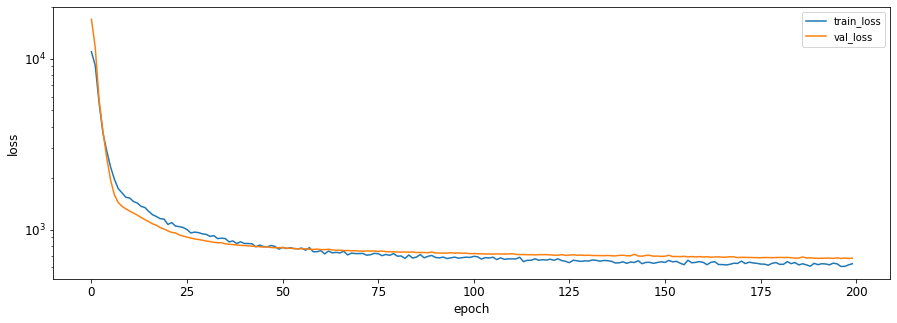

In [17]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor MLP

In [18]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
560.0541766346313
EQM final de validação após o término do treinamento - Preditor MLP
677.4033663749586
EQM final de teste após o término do treinamento - Preditor MLP
387.01914513151587


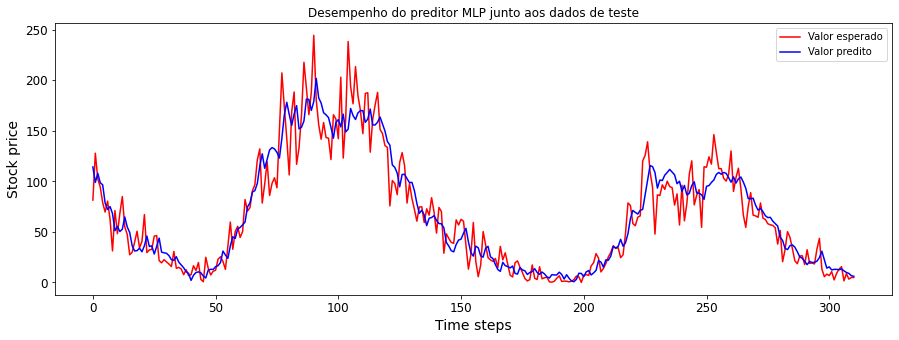

In [19]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

# Análise

- Preditor linear:
  - MSE treino: 592.38
  - MSE validação: 692.23
  - MSE teste: 406.04

- Preditor não-linear (MLP):
  - MSE treino: 560.05
  - MSE validação: 677.40
  - MSE teste: 387.02

- Decisões metodológicas:  
  - O número de atrasos considerados foi de 130. Esse número foi escolhido pelo fato de os dados de entrada apresentarem uma certa peridiocidade, sendo possível visualizar claramente 25 picos que podem ser associados com 25 períodos. Como a série inteira apresenta 3240 amostras, se dividirmos 3240/25, obtemos 129.6. Ou seja, o número de atrasos considerados para a formação dos dados corresponde a um período anterior. De fato, testando valores maiores e menores, o desempenho foi menor.
  - Arquitetura foi considerada para oferecer uma certa regularização ao modelo, ao empregar dropout. Learning rate e camadas foram ajustados na tentativa e erro. Ativação usada: "ReLU".

 - Resultados:  
  - Podemos ver que o preditor não-linear apresentou resultados um pouco melhores que o preditor linear. Isso pode ser explicado devido a não-linearidade apresentada nos dados, sendo portanto impossível de ser captada pelo preditor linear.

# End of Notebook